# Задача 5. Обучение без учителя

* **Дедлайн**: 14.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [ ] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [ ] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [ ] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [ ] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [ ] При обучении использовать **подбор гиперпараметров**.
- [ ] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [ ] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [ ] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

In [47]:
import time
from itertools import product

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.base import clone
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    fowlkes_mallows_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted

%matplotlib inline
%precision %.3f
import warnings

warnings.filterwarnings("ignore")

### Dataset
This is a Hiragana character dataset.
Contains 28x28 images of hiragana characters.
There are 10 classes.

0. Aa
1. Ka
1. Sa
1. Ta
1. Na
1. Ha
1. Ma
1. Ya
1. Ra
1. Wa


In [11]:
ds = "notshrirang/japanese-characters"
path = kagglehub.dataset_download(ds)

In [21]:
df_train = pd.read_csv(path + "/train_data.csv")
df_train_labels = df_train.pop("label")
df_test = pd.read_csv(path + "/test_data.csv")
df_test_labels = df_test.pop("label")

### EDA

In [22]:
df_train = df_train[:10000]
df_train_labels = df_train_labels[:10000]
df_test = df_test[:5000]
df_test_labels = df_test_labels[:5000]
df_train.drop(columns=["Unnamed: 0"], inplace=True)
df_test.drop(columns=["Unnamed: 0"], inplace=True)

In [23]:
print(df_train.shape, df_test.shape)
print(df_train_labels.value_counts(), df_test_labels.value_counts())
df_train.head()

(10000, 784) (5000, 784)
label
4    1061
3    1010
5    1008
9    1008
1    1003
2     989
0     987
7     985
6     982
8     967
Name: count, dtype: int64 label
1    530
0    516
4    513
6    506
8    504
2    495
3    492
7    491
5    485
9    468
Name: count, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,122,255,90,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,32,164,...,255,64,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 784 entries, 0 to 783
dtypes: int64(784)
memory usage: 59.8 MB


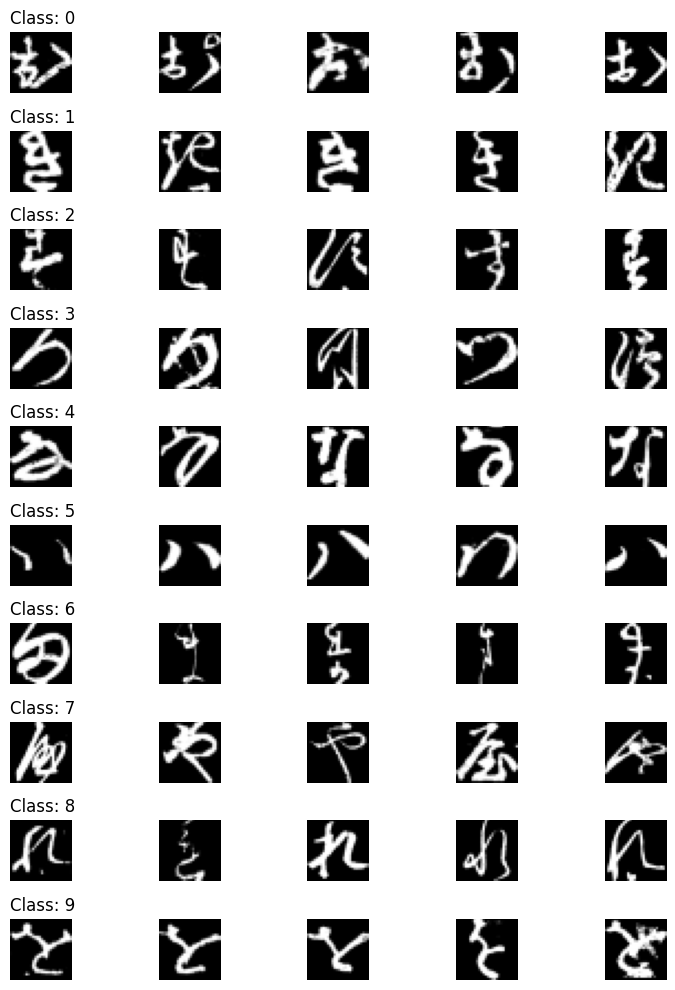

In [24]:
def visualize(X, Y):
    X = X.values
    Y = Y.values

    classes = np.unique(Y)
    classes.sort()
    num_classes = len(classes)

    fig, axes = plt.subplots(num_classes, 5, figsize=(8, num_classes))
    if num_classes == 1:
        axes = axes.reshape(1, -1)

    for i, cls in enumerate(classes):
        idx = np.where(Y == cls)[0]
        selected_idx = np.random.choice(idx, size=5, replace=False)

        for j, sample_idx in enumerate(selected_idx):
            img = X[sample_idx].reshape(28, 28)
            ax = axes[i, j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Class: {cls}", loc='left')

    plt.tight_layout()
    plt.show()


visualize(df_train, df_train_labels)

### PCA & t-SNE

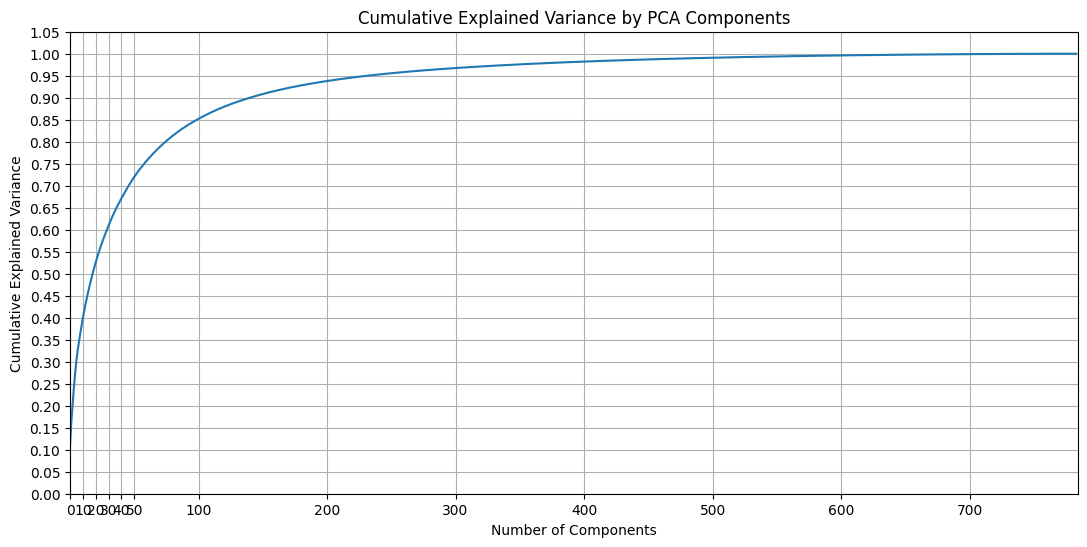

In [25]:
pca = PCA()
pca.fit(df_train)

plt.figure(figsize=(13, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.arange(0, 1.1, 0.05))
plt.xticks(list(plt.xticks()[0]) + [10, 20, 30, 40, 50])
plt.xlim(0, len(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA Components")
plt.show()

Из графика сделать следующие выводы:

 - размерность 20 охватывает больше половины дисперсии
 - размерность 70 - 80%
 - размерность 100 — 85%
 - размерность 140 — 90%
 - размерность 220 — 95%

Начиная с размерности 500, добавление новых измерений не увеличивает количество полезной информации.

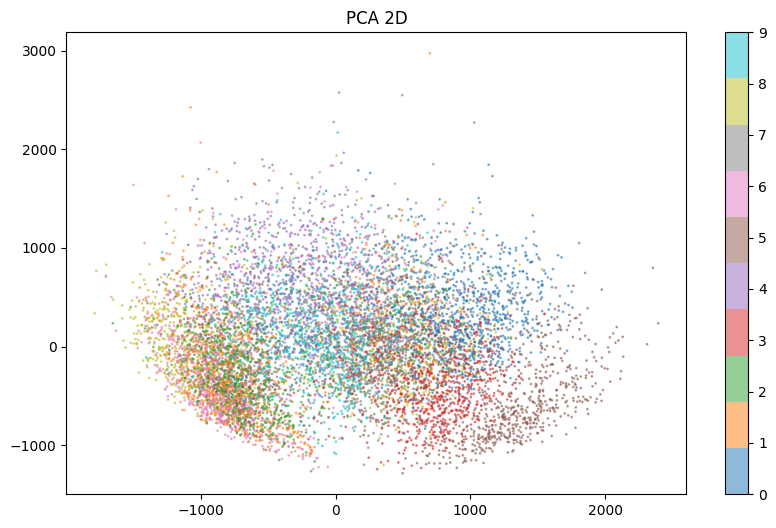

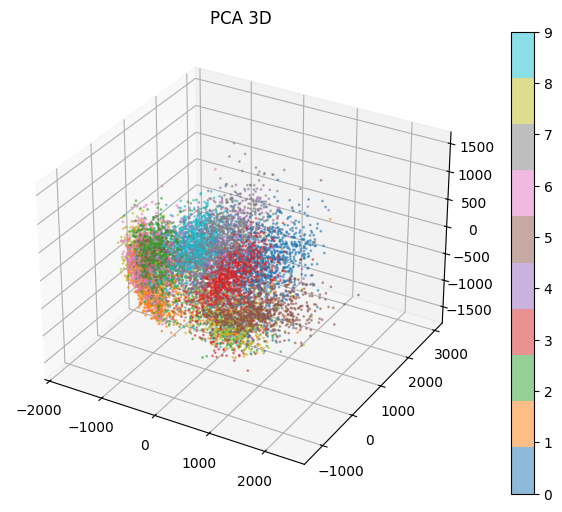

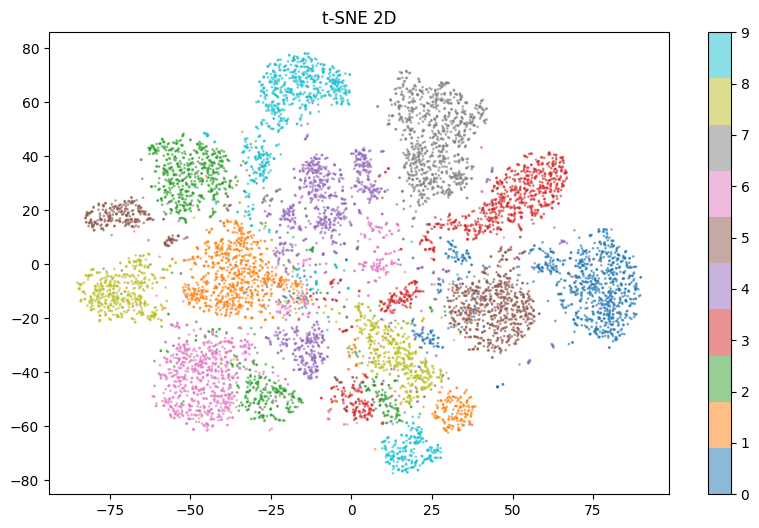

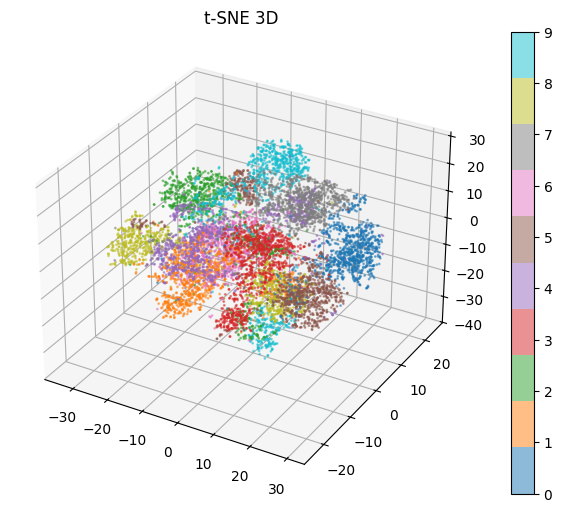

In [29]:
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(df_train)

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(df_train)

tsne_2d = TSNE(n_components=2, perplexity=30)
tsne_result_2d = tsne_2d.fit_transform(df_train)

tsne_3d = TSNE(n_components=3, perplexity=30)
tsne_result_3d = tsne_3d.fit_transform(df_train)


def plot_2d(result, title, labels):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        result[:, 0],
        result[:, 1],
        c=labels.astype("category").cat.codes,
        s=1,
        alpha=0.5,
        cmap="tab10",
    )
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()


def plot_3d(result, title, labels):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(
        result[:, 0],
        result[:, 1],
        result[:, 2],
        s=1,
        alpha=0.5,
        c=labels.astype("category").cat.codes,
        cmap="tab10",
    )
    plt.colorbar(scatter)
    ax.set_title(title)
    plt.show()


plot_2d(pca_result_2d, "PCA 2D", df_train_labels)
plot_3d(pca_result_3d, "PCA 3D", df_train_labels)

plot_2d(tsne_result_2d, "t-SNE 2D", df_train_labels)
plot_3d(tsne_result_3d, "t-SNE 3D", df_train_labels)

### K-Means

In [30]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def predict(self, x):
        check_is_fitted(self)
        return self._get_labels(check_array(x))

    def fit(self, x, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)

        self.n_features_in_ = x.shape[1]
        self.cluster_centers_ = x[self.random_state_.choice(len(x), size=self.n_clusters, replace=False), :]
        max_center_shift = np.inf

        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(x)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new[i] = np.mean(x[self.labels_ == i], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new, axis=1))

            self.cluster_centers_ = new

        return self

    def _get_labels(self, x):
        return np.argmin(np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1), axis=1)


### Обучение
Для оценки качества кластеризации на датасете изображений одежды были выбраны три метрики, а также дополнительно измерялось среднее время обучения алгоритмов.

 - **Adjusted Rand Index (ARI)**:
Оценивает согласованность между истинными и предсказанными кластерами, сравнивая попарные отношения между объектами. Метрика учитывает случайные совпадения и не зависит от обозначений кластеров.

 - **Adjusted Mutual Information (AMI)**:
Измеряет количество общей информации между двумя разбиениями, с корректировкой на случайные совпадения. Подходит для сравнения моделей с разным числом кластеров.

 - **Fowlkes-Mallows Index (FMI)**:
Представляет собой гармоническое среднее между точностью и полнотой кластеризации, позволяя оценить как способность алгоритма правильно объединять похожие объекты, так и избегать избыточного дробления.

In [31]:
def generate_param_combinations(param_grid):
    if not param_grid:
        return [{}]
    keys, values = zip(*param_grid.items())
    return [dict(zip(keys, prod)) for prod in product(*values)]

In [37]:
def evaluate_model_on_data(model, data, true_labels, param_combinations):
    best_results = {
        "ARI": {"score": -np.inf, "params": None, "time": None},
        "AMI": {"score": -np.inf, "params": None, "time": None},
        "FMI": {"score": -np.inf, "params": None, "time": None},
    }

    for params in param_combinations:
        estimator = clone(model).set_params(**params)
        start_time = time.perf_counter()
        predicted_labels = estimator.fit_predict(data)
        elapsed_time = time.perf_counter() - start_time

        scores = {
            "ARI": adjusted_rand_score(true_labels, predicted_labels),
            "AMI": adjusted_mutual_info_score(true_labels, predicted_labels),
            "FMI": fowlkes_mallows_score(true_labels, predicted_labels),
        }

        for metric, score in scores.items():
            if score > best_results[metric]["score"]:
                best_results[metric] = {
                    "score": score,
                    "params": params,
                    "time": elapsed_time
                }

    return best_results

In [38]:
def benchmark_clustering_model(estimator, param_grid, datasets, labels_list, output_path):
    param_combinations = generate_param_combinations(param_grid)
    results = []
    output_path = Path(output_path)

    for data, true_labels in zip(datasets, labels_list):
        best_scores = evaluate_model_on_data(estimator, data, true_labels, param_combinations)

        result = {
            "Model": estimator.__class__.__name__,
            "Features": data.shape[1],
            "Mean Time (s)": np.mean([best_scores[m]["time"] for m in best_scores]),
            "ARI": best_scores["ARI"]["score"],
            "AMI": best_scores["AMI"]["score"],
            "FMI": best_scores["FMI"]["score"],
        }

        print(result)
        results.append(result)

    df = pd.DataFrame(results)
    df.to_csv(output_path, mode="a", header=not output_path.exists(), index=False)

In [53]:
CLUSTERS = 10
OUTPUT_FILE = Path("clustering_benchmark.csv")

scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)

df_pca = [PCA(n_components=n).fit_transform(df_train_scaled) for n in [20, 70, 100, 140, 220]]
datasets = df_pca
labels_list = [df_train_labels] * len(df_pca)

models_to_benchmark = [
    {
        "name": "MyKMeans",
        "estimator": MyKMeans(n_clusters=CLUSTERS),
        "params": {}
    },
    {
        "name": "KMeans",
        "estimator": KMeans(n_clusters=CLUSTERS, n_init='auto'),
        "params": {
            "algorithm": ["lloyd", "elkan"]
        }
    },
    {
        "name": "DBSCAN",
        "estimator": DBSCAN(n_jobs=-1),
        "params": {
            "eps": [2 ** i for i in range(-2, 10)],
            "min_samples": [2 ** i for i in range(3, 7)]
        }
    },
]

In [54]:
for model_config in models_to_benchmark:
    benchmark_clustering_model(
        estimator=model_config["estimator"],
        param_grid=model_config["params"],
        datasets=datasets,
        labels_list=labels_list,
        output_path=OUTPUT_FILE
    )

{'Model': 'MyKMeans', 'Features': 20, 'Mean Time (s)': np.float64(1.2451996720046736), 'ARI': 0.3130378996621237, 'AMI': np.float64(0.43266911127008295), 'FMI': np.float64(0.3898777185511676)}
{'Model': 'MyKMeans', 'Features': 70, 'Mean Time (s)': np.float64(0.5035591270425357), 'ARI': 0.2853236949112503, 'AMI': np.float64(0.4142186497596379), 'FMI': np.float64(0.3662355041658338)}
{'Model': 'MyKMeans', 'Features': 100, 'Mean Time (s)': np.float64(0.9725778439897113), 'ARI': 0.3040698767284016, 'AMI': np.float64(0.43249035634253713), 'FMI': np.float64(0.3839154705149393)}
{'Model': 'MyKMeans', 'Features': 140, 'Mean Time (s)': np.float64(3.5042677730089054), 'ARI': 0.27808162572369205, 'AMI': np.float64(0.40161792988530176), 'FMI': np.float64(0.3616616189780556)}
{'Model': 'MyKMeans', 'Features': 220, 'Mean Time (s)': np.float64(15.55539932200918), 'ARI': 0.29847929933074635, 'AMI': np.float64(0.4196048289768347), 'FMI': np.float64(0.37959064875791254)}
{'Model': 'KMeans', 'Features': 

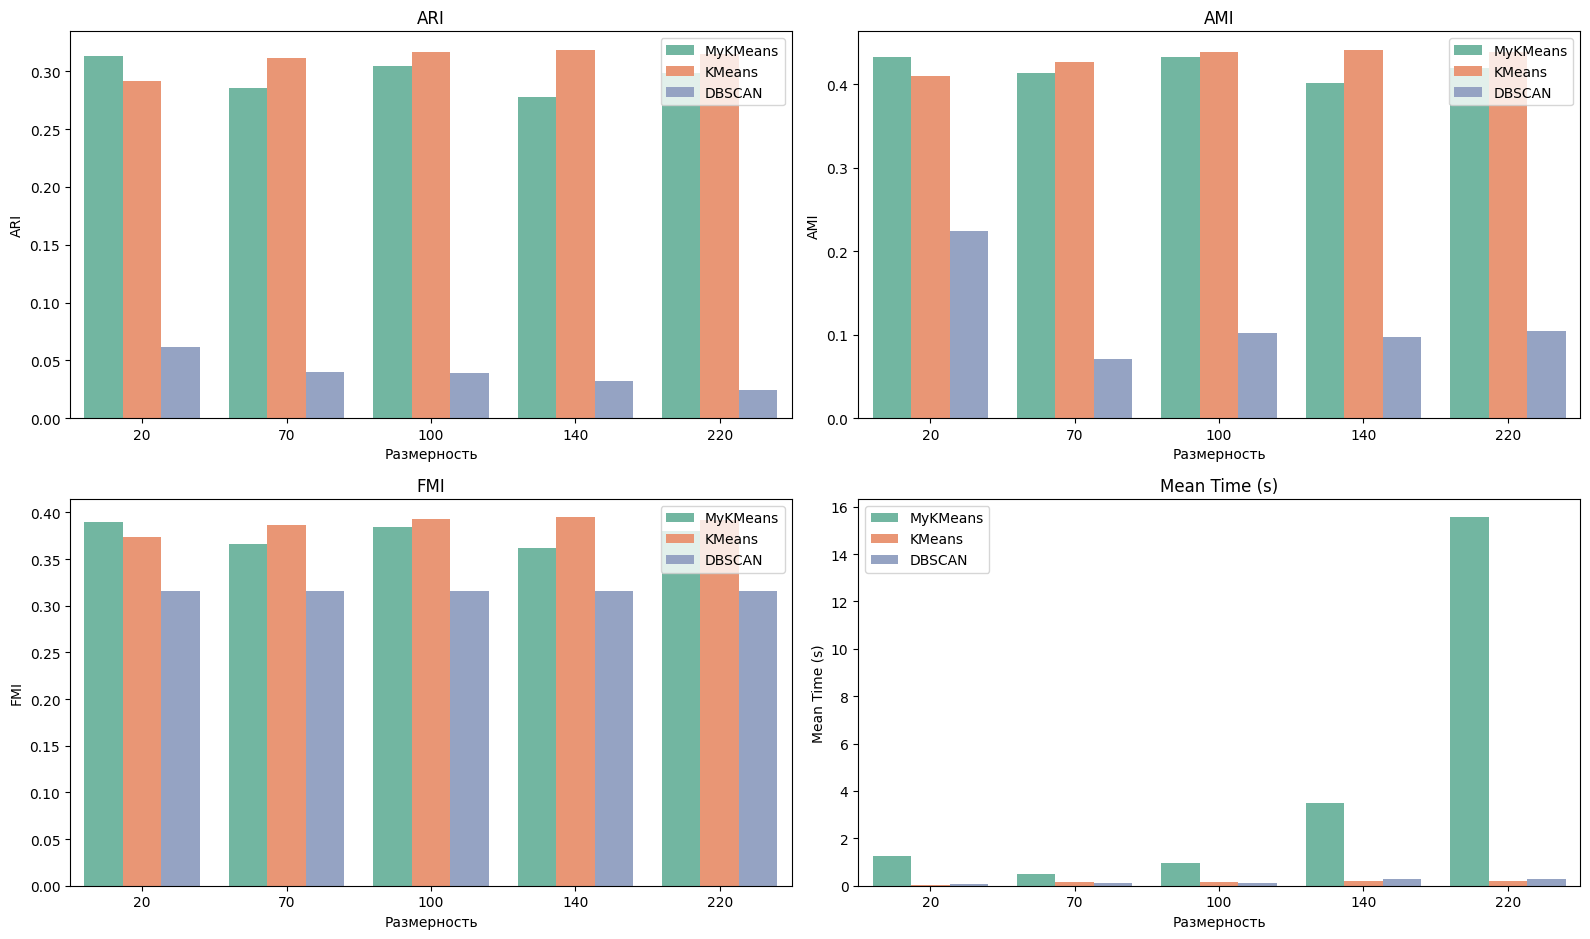

In [59]:
results_df = pd.read_csv(OUTPUT_FILE)

metrics = ["ARI", "AMI", "FMI", "Mean Time (s)"]
num_metrics = len(metrics)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, metric in enumerate(metrics):
    sns.barplot(
        data=results_df,
        x="Features",
        y=metric,
        hue="Model",
        ax=axes[idx],
        errorbar=None,
        palette="Set2"
    )
    axes[idx].set_title(metric)
    axes[idx].set_xlabel("Размерность")
    axes[idx].set_ylabel(metric)
    axes[idx].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Выводы

PCA значительно ускоряет обучение без потери качества кластеризации.

Обе версии KMeans (кастомная и из `scikit-learn`) показали высокое качество кластеризации. Разница между ними минимальна, при этом кастомная реализация в отдельных случаях показывает лучшие результаты.

По скорости библиотечный KMeans существенно превосходит кастомный из-за поддержки параллелизма.

DBSCAN уступает KMeans по всем метрикам качества и работает несколько медленнее, особенно при высокой размерности.

Наилучшее соотношение качества и скорости демонстрирует KMeans из `scikit-learn`.
